# Digit Recognizer(Kaggle Competition)

# Contents
* Preconfiguration
* Preprocessing
   * Loading Images
   * Transformation & Labeling
   * Checking For Balance Data
   * Shuffling
   * Train/Validation Split
   * Remove Outliers 
   * Remove Equal Images
   * Normalization
   * Augmentation
   * One Hot Encoding Labels
* Model Creation
    * simple NN
    * simple CNN
    * GoogLeNet
    * ResNet
* Training
* Evaluation

## Preconfiguration

In [5]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.keras.models import Model
from tensorflow.python import keras as K
from skimage.measure import compare_ssim as ssim
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D, Input, Dense, Flatten

In [6]:
data_root = 'data'
train_file = os.path.join(data_root,'train.csv')
test_file = os.path.join(data_root,'test.csv')
test_label_file = os.path.join(data_root,'sample_submission.csv')
img_shape = (28,28)

## Preprocessing

### Loading Images

In [7]:
tmp_train = pd.read_csv(train_file)
tmp_test = pd.read_csv(test_file)

In [8]:
tmp_train.sample(5)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
17130,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41359,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21028,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39825,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12054,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
tmp_test.head(5)

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Transformation & Labeling

In [11]:
def tranfrom_to_image_shape(data,shape) :
    data = np.array(data)
    img_data = np.ndarray((data.shape[0],shape[0],shape[1]))
    for i,img in enumerate(data) :
        for j,pixel in enumerate(img) :
            img_data[i,int(j/shape[0]),int(j%shape[1])] = pixel
    return img_data
tmp_img_train = tranfrom_to_image_shape(tmp_train.drop('label',axis=1),img_shape)
tmp_img_test = tranfrom_to_image_shape(tmp_test,img_shape)
labels = tmp_train['label']

Making Sure That transformation and labeling are working fine

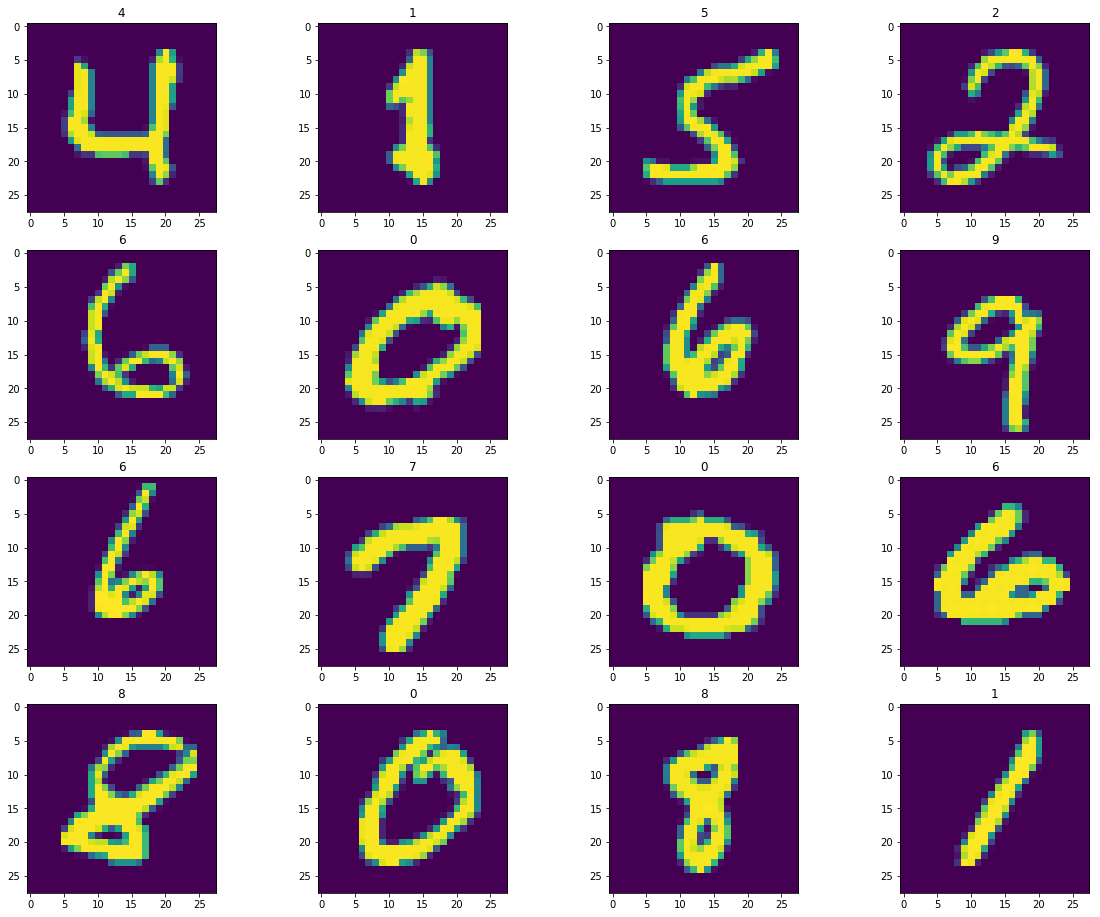

In [12]:
def img_random_visualization(imgs,labels) :
    f,ax = plt.subplots(4,4,figsize=(20,16))
    for i in ax :
        for j in i :
            rnd = np.random.randint(imgs.shape[0])
            j.set_title(labels[rnd])
            j.imshow(imgs[rnd])
img_random_visualization(tmp_img_train,labels)

### Checking For Balance Data

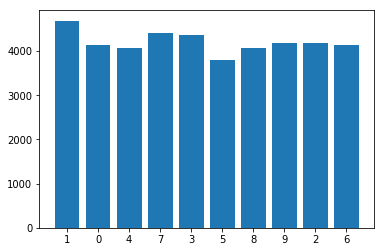

In [13]:
def hist_calc(arr) :
    dic = {}
    for i in arr :
        if i in dic :
            dic[i] += 1
        else :
            dic[i] = 1
    return dic

def hist_visualizer(dic) :
    plt.bar(range(len(dic)), list(dic.values()), align='center')
    plt.xticks(range(len(dic)), list(dic.keys()))
    plt.show()

hist_visualizer(hist_calc(labels))

As you see data is nearly balanced.

### Shuffling

In [14]:
def shuffle_dataset(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation,:,:]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels
tmp_img_train,labels = shuffle_dataset(tmp_img_train,labels)

### Train/Validation Split

In [15]:
X_train, X_valid, y_train, y_valid = train_test_split(tmp_img_train, labels, test_size=.15)
print('train dataset shape : {} \ntrain label shape : {} \nvalidation dataset shape : {} \nvalidation label shape : {}'.format(X_train.shape,y_train.shape,X_valid.shape,y_valid.shape))

train dataset shape : (35700, 28, 28) 
train label shape : (35700,) 
validation dataset shape : (6300, 28, 28) 
validation label shape : (6300,)


### Remove Equal Images

In [12]:
def displayIdenticalImgs(dataset) :
    for i,sample in enumerate(dataset) :
        plt.subplot(4,3,1+i)
        plt.axis('off')
        plt.imshow(sample)

def overlapping_measure(dataset_1,dataset_2) :
    similarity_score = 0.0
    similar_images = {}
    similar_imgs_index_2 = []
    for i,m_1 in enumerate(dataset_1) : 
        for j,m_2 in enumerate(dataset_2) :
            if (ssim(m_1,m_2) > .85) : 
                if j not in similar_imgs_index_2 :
                    similarity_score += 1
                    similar_imgs_index_2.append(j)
                if i not in similar_images.keys() :
                    similar_images[i] = []
                    similarity_score += 1
                similar_images[i].append(m_2)
    # calculating the overlapping Score
    overlapping_score = similarity_score / (dataset_1.shape[0] + dataset_2.shape[0])
    return (similar_images,similar_imgs_index_2,overlapping_score)

train_valid_similar_imgs,valid_train_similar_indexes,train_valid_overlapping_score = overlapping_measure(X_train[:1000],X_valid[:1000])
print("train & test dataset Overlapping Percent : %f" % train_valid_overlapping_score)

train & test dataset Overlapping Percent : 0.064000


train & test dataset Overlapping Images : 


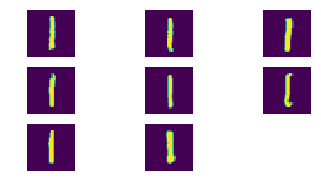

In [13]:
sample = np.random.choice(list(train_valid_similar_imgs.keys()))
print("train & test dataset Overlapping Images : ")
displayIdenticalImgs(np.append([X_train[sample]],train_valid_similar_imgs[sample],axis=0))

### Normalization

In [16]:
X_norm_train = tf.Session().run(tf.map_fn(lambda img: tf.image.per_image_standardization(img),X_train.reshape(-1,*img_shape,1).astype(np.float32)))
X_norm_valid = tf.Session().run(tf.map_fn(lambda img: tf.image.per_image_standardization(img),X_valid.reshape(-1,*img_shape,1).astype(np.float32)))

### Augmentation

### One Hot Encoding 

In [17]:
y_norm_train = tf.Session().run(tf.one_hot(y_train,10))
y_norm_valid = tf.Session().run(tf.one_hot(y_valid,10))

## Model Creation

In [27]:
def train_model(inputs, predictions,optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy']) :
    model = Model(inputs=inputs, outputs=predictions)
    model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)
    return model

### Simple Neural Network

In [18]:
def get_nn_model(input_shape,output_shape) :
    # This returns a tensor
    inputs = Input(shape=input_shape)
    # Flattening The Image
    x = Flatten()(inputs)
    # a layer instance is callable on a tensor, and returns a tensor
    x = Dense(64, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    predictions = Dense(output_shape, activation='softmax')(x)

    # This creates a model that includes
    # the Input layer and three Dense layers
    return inputs,predictions

In [28]:
nn_model = train_model(*get_nn_model((*img_shape,1),10))

In [29]:
nn_model.fit(X_norm_train,y_norm_train,validation_data=(X_norm_valid,y_norm_valid),)

Train on 35700 samples, validate on 6300 samples
Epoch 1/1
35700/35700 [==============================] - 5s 152us/step - loss: 0.2845 - acc: 0.9143 - val_loss: 0.1781 - val_acc: 0.9437


### Convolutional Neural Network

In [26]:
def get_cnn_model(input_shape,output_shape) :
    inputs = Input(shape=input_shape)
    y = Conv2D(16, 5, padding='same', activation='selu')(inputs)
    y = Conv2D(16, 5, padding='same', activation='selu')(y)
    y = Conv2D(16, 5, padding='same', activation='selu')(y)
    y = Conv2D(16, 5, padding='same', activation='selu')(y)
    y = Conv2D(16, 5, padding='same', activation='selu')(y)

    y = Flatten()(y)
    y = Dense(64, activation='selu')(y)
    y = Dense(64, activation='selu')(y)
    predictions = Dense(10, activation='softmax')(y)

    return inputs,predictions

In [30]:
cnn_model = train_model(*get_cnn_model((*img_shape,1),10))

In [32]:
cnn_model.fit(X_norm_train,y_norm_train,validation_data=(X_norm_valid,y_norm_valid),epochs=3)

Train on 35700 samples, validate on 6300 samples
Epoch 1/3
35700/35700 [==============================] - 19s 532us/step - loss: 0.1334 - acc: 0.9782 - val_loss: 0.1748 - val_acc: 0.9700
Epoch 2/3
35700/35700 [==============================] - 19s 532us/step - loss: 0.1260 - acc: 0.9797 - val_loss: 0.1415 - val_acc: 0.9819
Epoch 3/3
35700/35700 [==============================] - 19s 531us/step - loss: 0.1209 - acc: 0.9828 - val_loss: 0.2175 - val_acc: 0.9776
